### Introduction


This notebook is a proof-of-principle implementation of the algorithm for reachability analysis of nonlinear systems using zonotopes presented in [1, Section 3], see also [2].

---

**References:**

[1] Althoff, Matthias. Reachability analysis and its application to the safety
assessment of autonomous cars. Diss. Technische Universität München, 2010.

[2] M. Althoff, O. Stursberg, and M. Buss. [Reachability analysis of nonlinear systems with uncertain parameters using conservative linearization.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.148.9110&rep=rep1&type=pdf) In Proc. of the 47th IEEE Conference on Decision and Control, pages 4042–4048, 2008.

In [1]:
# load packages

using Plots

using LazySets, MathematicalSystems, Reachability
using Reachability: center
using IntervalArithmetic, ValidatedNumerics
using LazySets: Interval, translate
using TaylorSeries
using TaylorSeries: gradient, jacobian, hessian, derivative
const ∂ = derivative

derivative (generic function with 10 methods)

### Assumptions

To simplify the presentation let's assume that the ODE is autonomous and there is no input, ie. it is of the form $x'(t) = f(x(t))$ with $f : \mathbb{R}^n \mapsto \mathbb{R}^n$ continuously differentiable.

### Running example

To fix ideas we will use the Van der Pol ODE with $\mu = 1$. It is given by the map $$f : (x_1, x_2) \mapsto (x_2, x_2(1-x_1^2) - x_1),$$ with initial set given by $x_1(0) \in [1.25, 1.55] $ and $x_2 \in [2.35, 2.45]$ and time horizon $T = 7.0$ seconds.

We implement it as a vector of multivariate polynomials (`TaylorN`'s):

In [2]:
# number of Taylor terms considered in the linearization
taylor_terms = 4

# define the working variables and fix the max order in the Taylor series expansion
x = set_variables("x", numvars=2, order=taylor_terms)

2-element Array{TaylorN{Float64},1}:
  1.0 x₁ + 𝒪(‖x‖⁵)
  1.0 x₂ + 𝒪(‖x‖⁵)

In [3]:
f = Vector{TaylorN{Float64}}(undef, 2)
f[1] = x[2]
f[2] = x[2] * (1-x[1]^2) - x[1]

 - 1.0 x₁ + 1.0 x₂ - 1.0 x₁² x₂ + 𝒪(‖x‖⁵)

In [4]:
𝑋₀ = Hyperrectangle(low=[1.25, 2.35], high=[1.55, 2.45])
𝑆 = BlackBoxContinuousSystem(f, 2)
𝑃 = InitialValueProblem(𝑆, 𝑋₀)

InitialValueProblem{BlackBoxContinuousSystem{Array{TaylorN{Float64},1}},Hyperrectangle{Float64}}(BlackBoxContinuousSystem{Array{TaylorN{Float64},1}}(TaylorN{Float64}[ 1.0 x₂ + 𝒪(‖x‖⁵),  - 1.0 x₁ + 1.0 x₂ - 1.0 x₁² x₂ + 𝒪(‖x‖⁵)], 2), Hyperrectangle{Float64}([1.4, 2.4], [0.15, 0.05]))

### Linearization

In this step we linearize the ODE $x'(t) = f(x(t))$ with a fixed step size $\delta$ and compute:

- $\mathcal{R}^{lin}(\delta)$, an overapproximation of the state reachable at time $\delta$ of the linearized system,
- $\mathcal{R}^{lin}([0, \delta])$, an overapproximation of the flowpipe in dense time $[0, \delta]$ for the linearized system.

For $i = 1, 2$, recall that the *gradient* of the scalar field $f_i$ is the function $\nabla f_i : (x_1, x_2) \mapsto (\partial_1 f_i, \partial_2 f_i)$, where $\partial_i$ is a shortcut for the partial derivative $\dfrac{\partial}{\partial x_i}$. For higher order derivatives we use $\partial_{ij\ldots}$ for example $\dfrac{\partial^2 f_i}{\partial x_1\partial x_2} = \partial^2_{12}f_i$.

We can use the `gradient` function from `TaylorSeries` to compute a gradient symbolically. For our example, we obtain by differentiation that

$$
\nabla f_1 = (0, 1) \\
\nabla f_2 = (-2x_1x_2 - 1, 1-x_1^2)
$$

Now let's compute it using `gradient`:

In [5]:
∇f = [gradient(f[i]) for i in 1:2];

In [6]:
∇f[1]

2-element Array{TaylorN{Float64},1}:
  0.0 + 𝒪(‖x‖⁵)
  1.0 + 𝒪(‖x‖⁵)

In [7]:
∇f[2]

2-element Array{TaylorN{Float64},1}:
  - 1.0 - 2.0 x₁ x₂ + 𝒪(‖x‖⁵)
      1.0 - 1.0 x₁² + 𝒪(‖x‖⁵)

The Taylor series expansion of the function $f(x)$ around point $x̃$ is:

$$
f_i(x) = f_i(x̃) + \nabla f_i(x̃) \cdot (x-x̃) + \frac{1}{2} (x-x̃)^T H_{f_i}(x̃) (x-x̃) + \ldots,\qquad i = 1,2.
$$

There are different ways to account for the linearization error. If we consider the Lagrange remainder, then:
$$
f_i(x) = f_i(x̃) + \nabla f_i(x̃) \cdot (x-x̃) +  L_i(x, x̃),
$$
where the Lagrangian $L_i$ is defined as
$$
L_i(x, x̃) = \frac{1}{2} (x-x̃)^T H_{f_i}(ξ) (x-x̃), \qquad i = 1,2.
$$
where $ξ$ lives in the convex hull $ξ = CH(x̃, x) = \{x̃ + \alpha(x - x̃), \alpha \in [0, 1]\}$.

The linearized function can be succintly written using the Jacobian matrix. Recall that the Jacobian matrix is such that $[J_f]_{ij} = \partial_j f_i$ for $i, j = 1, 2$. Then 

$$
f^{lin}(x) := f(x̃) + J_f(x̃) \cdot (x-x̃) = A \cdot x + b,
$$
where
$$
A := J_f(x̃),\qquad b := f(x̃) - J_f(x̃) \cdot x̃.
$$

In [8]:
# Jf = Matrix{TaylorN{Float64}}(undef, 2, 2)
Jf = [∂(f[1], (1, 0)) ∂(f[1], (0, 1));
      ∂(f[2], (1, 0)) ∂(f[2], (0, 1))]

2×2 Array{TaylorN{Float64},2}:
                0.0 + 𝒪(‖x‖⁵)             1.0 + 𝒪(‖x‖⁵)
  - 1.0 - 2.0 x₁ x₂ + 𝒪(‖x‖⁵)   1.0 - 1.0 x₁² + 𝒪(‖x‖⁵)

For the linearization point we use the shifted center of initial states, as in [1]:

In [9]:
δ = 0.05 # step size

c = center(𝑋₀)
x̃ = c + δ/2 * f(c)  # linearization point

2-element Array{Float64,1}:
 1.46              
 2.3074000000000003

In [10]:
x̃ ∈ 𝑋₀

false

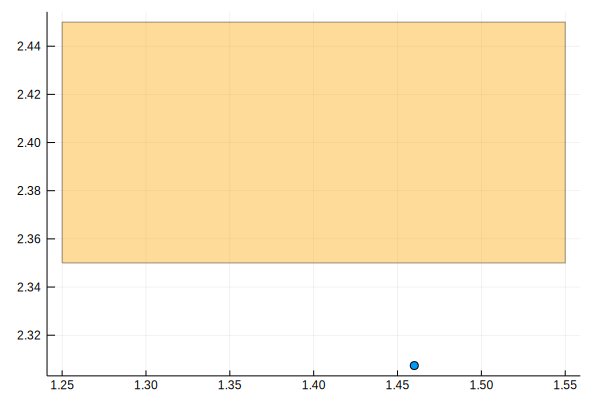

In [11]:
plot(Singleton(x̃))
plot!(𝑋₀, alpha=.4, color=:orange)

In [12]:
Ax̃ = map(x -> evaluate(x, x̃), Jf)
# Ax̃ = jacobian(f, x̃) # the same using TaylorSeries.jacobian
bx̃ = f(x̃) - Ax̃ * x̃
𝑆lin = ConstrainedAffineContinuousSystem(Ax̃, bx̃, Universe(2)) # no state constraints

ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},Universe{Float64}}([0.0 1.0; -7.73761 -1.1316], [0.0, 9.83691], Universe{Float64}(2))

Next we overapproximate the flowpipe for the linearized system. We can use different set representations. For example, we can use `GLGM06` that computes with zonotopes (as in [Chapter 3, 1]).

In [13]:
δcont = δ / 10

𝑃lin = InitialValueProblem(𝑆lin, 𝑋₀)
@time Rlin = solve(𝑃lin, Options(:T=>δ), op=GLGM06(:δ=>δcont, :max_order=>2));

 28.730305 seconds (67.33 M allocations: 3.415 GiB, 9.81% gc time)


In [14]:
length(sol.Xk)

UndefVarError: UndefVarError: sol not defined

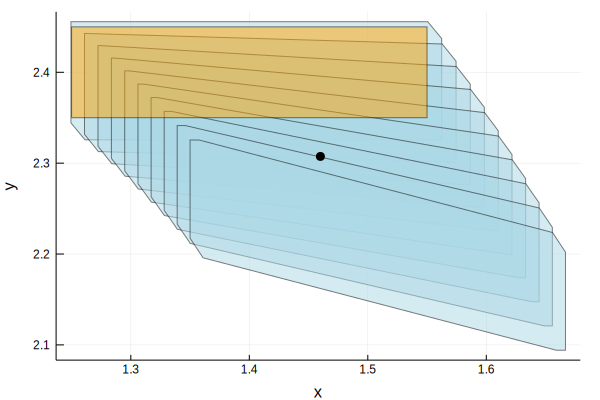

In [15]:
plot(Rlin, color=:lightblue, alpha=.5)
plot!(𝑋₀, color=:orange, alpha=.5, xlab="x", ylab="y")
plot!(Singleton(x̃), color=:black) # linearization point

Another run but this time using a five times larger time horizon in the continuous post:

  0.019953 seconds (19.60 k allocations: 1.594 MiB)


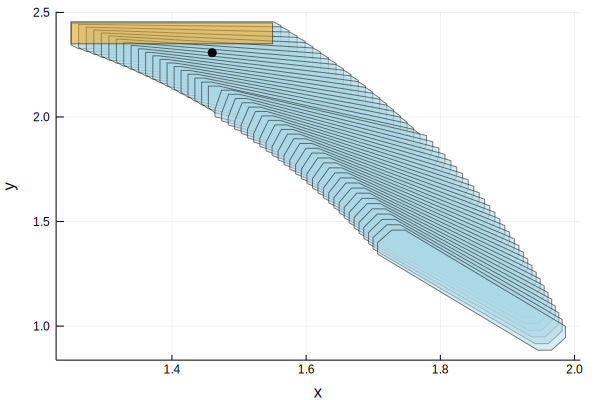

In [16]:
δcont2 = δ / 10
𝑆lin2 = deepcopy(𝑆lin)
𝑋₀2 = deepcopy(𝑋₀)
𝑃lin2 = InitialValueProblem(𝑆lin2, 𝑋₀2)
@time Rlin2 = solve(𝑃lin2, Options(:T=>5*δ), op=GLGM06(:δ=>δcont, :max_order=>2));
plot(Rlin2, color=:lightblue, alpha=.5)
plot!(𝑋₀2, color=:orange, alpha=.5, xlab="x", ylab="y")
plot!(Singleton(x̃), color=:black) # linearization point

### Computation of the set of admissible linearization errors $\bar{L}$

We use the approach in [1] where the rate of growth of the admissible linearization error is bounded with a multi-dimensional interval by an expansion vector $\theta$. For our running example, we consider the expansion vector $\theta = [0.05, 0.05]$:

In [17]:
θ = fill(0.05, 2)

2-element Array{Float64,1}:
 0.05
 0.05

The term $A^{-1}(e^{A\delta} - I)$ can be computed using `Φ₁` implemented in Reachablity. We don't need to assume that $A$ is invertible, since we can use the series expansion of the exponential matrix. See the documentation of `using Reachability.ReachSets: Φ₁` for details.

In [18]:
using Reachability.ReachSets: Φ₁

In [19]:
Φ₁_Aδ = Φ₁(Ax̃, δ)

2×2 Array{Float64,2}:
  0.0498412   0.00122479
 -0.00947691  0.0484552 

In [20]:
R̄err = Hyperrectangle(zeros(2), θ*δ)

Hyperrectangle{Float64}([0.0, 0.0], [0.0025, 0.0025])

In [21]:
l̄ = abs.(inv(Φ₁_Aδ)) * θ * δ
L̄ = Hyperrectangle(zeros(2), l̄)

Hyperrectangle{Float64}([0.0, 0.0], [0.0511812, 0.0611105])

### Computation of the set of linearization errors $L$

The computation of the set of linearization errors is performed using the computed flowpipe of the linearized system and the admissible linearization errors as described below, following [1].

In particular, we use interval arithmetics to bound the lagrangian $L_i$ by a multi-dimensional interval.

Recall from the linearization section that the linearization error $L_i$ is obtained by an evaluation of the Lagrange remainder,

$$
L_i(x, x̃) = \frac{1}{2} (x-x̃)^T H_{f_i}(ξ) (x-x̃), \qquad i = 1,2.
$$
where $ξ$ lives in the convex hull $ξ = CH(x̃, x) = \{x̃ + \alpha(x - x̃), \alpha \in [0, 1]\}$.

Let's compute the Hessian matrix:

In [22]:
#Hf = Matrix{TaylorN{Float64}}(undef, 2, 2)
Hf₁ = [∂(f[1], (2, 0)) ∂(f[1], (1, 1));
       ∂(f[1], (1, 1)) ∂(f[1], (0, 2))]

2×2 Array{TaylorN{Float64},2}:
  0.0 + 𝒪(‖x‖⁵)   0.0 + 𝒪(‖x‖⁵)
  0.0 + 𝒪(‖x‖⁵)   0.0 + 𝒪(‖x‖⁵)

In [23]:
Hf₂ = [∂(f[2], (2, 0)) ∂(f[2], (1, 1));
       ∂(f[2], (1, 1)) ∂(f[2], (0, 2))]

2×2 Array{TaylorN{Float64},2}:
  - 2.0 x₂ + 𝒪(‖x‖⁵)   - 2.0 x₁ + 𝒪(‖x‖⁵)
  - 2.0 x₁ + 𝒪(‖x‖⁵)        0.0 + 𝒪(‖x‖⁵)

*Note.* The jacobian and hessian matrices can also be computed numerically with `TaylorSeries`, eg. 

In [24]:
d = rand(2)
hessian(f[2], d)

2×2 Transpose{Float64,Array{Float64,2}}:
 -1.32356   -0.502717
 -0.502717   0.0     

In [25]:
map(x -> evaluate(x, d), Hf₂)

2×2 Array{Float64,2}:
 -1.32356   -0.502717
 -0.502717   0.0     

To compute $L_i$ for the dense time interval $t \in [0, \delta]$ we have to consider possible values of $x$ within this time interval. Since $\mathcal{R}([0, \delta])$ is not known in advance, we need to somehow approximate this flowpipe and then validated it. The exact values of $x$ are overapproximated by $\mathcal{R}^{lin}([0, \delta]) \oplus \bar{R}^{err}$.

In [26]:
# admissible reachable set
Rlin_plus_R̄err = [Ri.X ⊕ R̄err for Ri in Rlin.Xk];

The Lagrange remainder terms $L_i$ are overapproximated in two ways:

1. using interval arithmetic on the quadratic expression
2. using the zonotopic overapproximation from [Prop. 3.7, 1].

Let's take approach 1. The possible values of $x$ are included in the set $\mathcal{R}^{lin}([0, \delta]) \oplus \bar{R}^{err}$.

Let $\hat{R}^{lin}$ be the minimum bounding box that includes these sets. Since the convex hull and Minkowski sum are commuting operations, we can do

$$
\hat{R}^{lin} := CH(\mathcal{R}^{lin}(0), \mathcal{R}^{lin}(\delta_{cont}), \mathcal{R}^{lin}(2\delta_{cont}), \ldots, \mathcal{R}^{lin}(\delta))\oplus \bar{R}^{err}.
$$

In [27]:
R̂lin = ConvexHullArray([Ri.X for Ri in Rlin.Xk]) ⊕ R̄err;

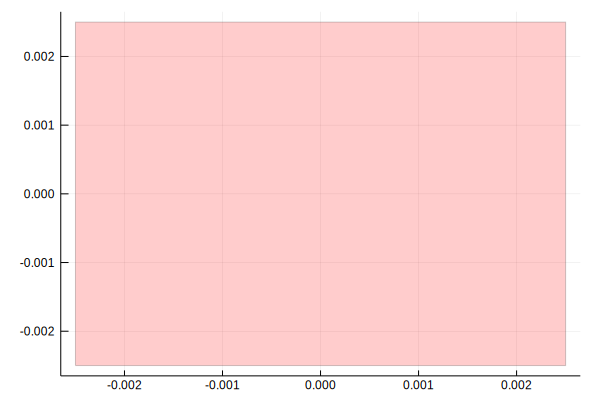

In [28]:
# the error is a box around the origin
plot(R̄err, alpha=.2, color="red")

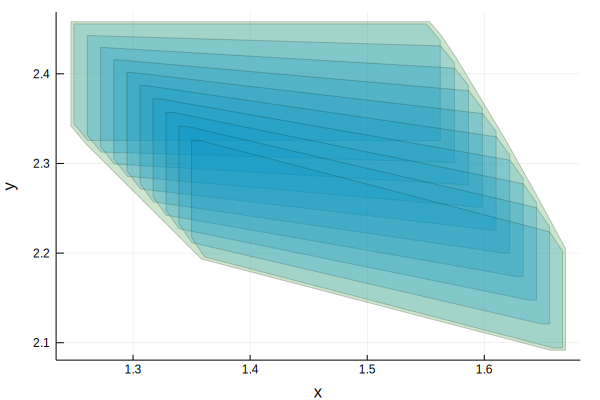

In [29]:
plot(Rlin, alpha=.2)
plot!(R̂lin, alpha=.2, 1e-3, xlab="x", ylab="y", color="green")

In [30]:
#B = IntervalBox(0.)
#evaluate(Hf₂[1], B)

### Inclusion check

In [31]:
L ⊆ Lbar

UndefVarError: UndefVarError: L not defined

- if $L \subseteq \bar{L}$, then the linearization error is accepted and the reachable set is obtained by superposition of the reachable set without linearization error and the one due to the linearization error: $\mathcal{R}(\delta) = \mathcal{R}^{lin}(\delta) + \mathcal{R}^{err}$ and $\mathcal{R}([0, \delta]) = \mathcal{R}^{lin}([0, \delta]) + \mathcal{R}^{err}$

- otherwise, the linearization error is not admissible, requiring the initial reachable set $\mathcal{R}((k-1)\delta))$; for the first step $X_0$ to be split into two reachable sets. Then we perform the reachable set computations for both of the newly obtained sets once more.